In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
import survivors.datasets as ds
import survivors.constants as cnt

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


### Структура

Вариант 1: стратифицированные модели

Вариант 2: стратифицированные модели только на категориальных

Вариант 3: стратифицированные и стекинговые модели


In [17]:
glob_dir = os.path.join(os.path.split(os.path.split(os.getcwd())[0])[0], "experiment_results", "Backblaze")

========== backblaze16_18 ==========
                               CI IAUC_WW_TI
$BaseLeafModel$            0.5000     0.4985
$CoxPH$                    0.4202   *0.8194*
$CoxPH+TREE(d=1)$          0.5280     0.5892
$CoxPH+TREE(d=10)$         0.5393     0.7266
$CoxPH+TREE(d=2)$          0.5649     0.7053
$CoxPH+TREE(d=3)$          0.5674     0.7163
$CoxPH+TREE(d=5)$          0.5533   *0.7490*
$CoxPH+TREE(d=7)$          0.5632     0.7182
$KM$                       0.5000     0.4985
$LogLogisticAFT$           0.4406   *0.8166*
$LogNormalAFT$             0.4966     0.5872
$ST$                       0.5422     0.6678
$WeibullAFT$               0.4595     0.5626
$WeibullAFT+TREE(d=1)$     0.5280     0.5892
$WeibullAFT+TREE(d=10)$    0.5742     0.6363
$WeibullAFT+TREE(d=2)$     0.5602     0.6934
$WeibullAFT+TREE(d=3)$     0.5715     0.6818
$WeibullAFT+TREE(d=5)$   *0.6188*     0.6963
$WeibullAFT+TREE(d=7)$     0.5527     0.6622
$base+TREE(d=1)$           0.5280     0.5892
$base+TREE(d=10)$ 

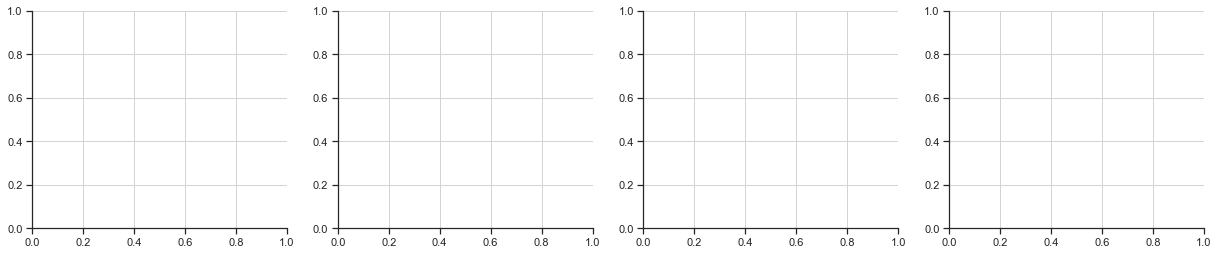

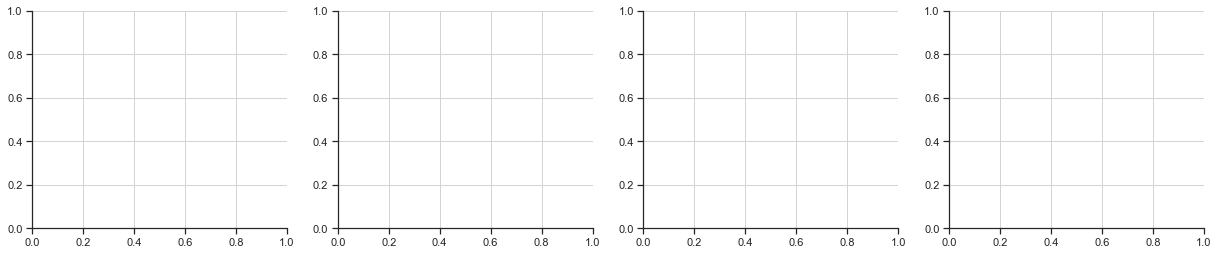

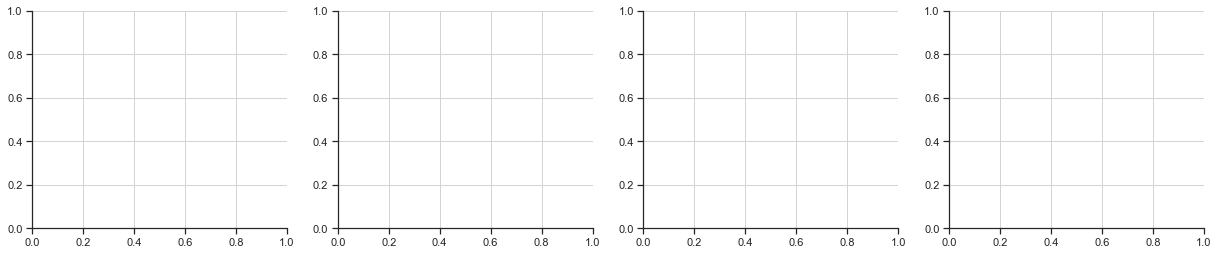

In [31]:
METHOD_MAP = {
    "CRAID": "TREE",
    "BootstrapCRAID": "BSTR", 
    "ParallelBootstrapCRAID": "PBSTR",
    "BoostingCRAID": "BOOST", 
    "IBSCleverBoostingCRAID": "BSTR",
    "CoxPHSurvivalAnalysis": "CoxPH",
    "SurvivalTree": "ST",
    "RandomSurvivalForest": "RSF",
    "ComponentwiseGradientBoostingSurvivalAnalysis": "CWGBSA",
    "GradientBoostingSurvivalAnalysis": "GBSA",
    "LeafSurviveAndHazard": "KM",
    "BaseLeafModeLL": "KM",
    "deepsurvCRAID": "DeepSurv",
    "coxtimeCRAID": "CoxTime"}

STAT_m = ['BaseLeafModeLL']
ML_m = ["CoxPH", 'ST']
SELF_m = ['TREE', 'TREE_KMWV']

def define_name(x):
    m = x["METHOD"]
    s = m.split("_")
    m = METHOD_MAP.get(s[0], s[0])
    if len(s) > 1:
#         m = s[1]
        m += "_" + s[1]
        # m += "_{" + s[1] + "}"
    s = str(x["ens_metric_name"])
    l_m = str(x["l_m"])
    cr = str(x["CRIT"])
    d = str(x["depth"])
    if len(d) > 0:
        return fr"${l_m}+{m}(d={d})$"
#         return fr"${m}({cr})$"
    return fr"${m}$"

def find_best_index(df):
    ens_name = "IBS_REMAIN"
    
    if ens_name in metr.DESCEND_METRICS:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=True).index[:5].tolist()
    else:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=False).index[:5].tolist()
    return best_index

def add_star_top3(column, filter_self=False):
    if filter_self:
        top_index = column[column.index != column.name.replace('_', '-')].argsort()
    else:
        top_index = column.argsort()
        
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        top3_index = top_index[:3]
    else:
        top3_index = top_index[-3:]
#     column.iloc[top3_index] = "\\textbf{" + column.iloc[top3_index].astype(str) + "}"
    column.iloc[top3_index] = "*" + column.iloc[top3_index].astype(str) + "*"
    return column

def rank_values(column, filter_self=False):
    top_index = column.argsort().argsort()
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        return top_index + 1
    return top_index.shape[0] - top_index

def pair_compare_load(dataset, group, ch_met):
    dfs = []
    for c_m in ch_met:   
        datasets_sc = f"{c_m}_STRATTIME+_tree_{dataset}_CV_full.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"]
        dfs.append(df_sc)
    
        datasets_sc = f"{c_m}_STRATTIME+_scsurv_{dataset}_CV_full.xlsx"
        dfs.append(pd.read_excel(os.path.join(glob_dir, datasets_sc)))

    tg_metrs_1 = ["CI", "IAUC_WW_TI"]  # , "IBS_REMAIN", "AUPRC"
    tg_metrs = ["CI_mean", "IBS_REMAIN_mean", "IAUC_WW_TI_mean", "AUPRC_mean"]  #, "LOGLIKELIHOOD_mean"]
    new_metrs = tg_metrs_1
    
    df = pd.concat(dfs, ignore_index=True)
    
    df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x).get("ens_metric_name", ""))
    
    df["l_m"] = df["PARAMS"].apply(lambda x: eval(x).get("leaf_model", ""))
    df["depth"] = df["PARAMS"].apply(lambda x: eval(x).get("depth", ""))
    df["METHOD"] = df.apply(define_name, axis=1)
    df = df[~df["METHOD"].isin(["$RSF$", "$GBSA$", "$CWGBSA$"])]
    df = df.loc[df.groupby('METHOD')["IBS_REMAIN_mean"].idxmin()]
    df["METHOD"] = df["METHOD"].astype("category")
    
    f, axes = plt.subplots(1, 4, figsize=(21, 4))
    l_df = []
    for i, v in enumerate(tg_metrs_1):
        df[new_metrs[i]] = df[tg_metrs_1[i]]
        v = new_metrs[i]
        df[v] = df[v].apply(lambda x: np.array(list(map(float, x[1:-1].split()))))
        explode_res = df[[v, "METHOD"]].set_index(['METHOD']).apply(lambda x: x.explode()).reset_index()
        l_df.append(explode_res.groupby(by="METHOD").agg(lambda x: f"{x.mean():.4f}"))
#         axes[i] = explode_res.boxplot(column=v, by="METHOD", figsize=(10, 10), rot=45, ax=axes[i], showfliers=False, whis=0)
#         axes[i].set_ylabel(v)
#         axes[i].set_title("")
    res_table = pd.concat(l_df, axis=1)#.astype(float).round(4)
    res_table.index = list(map(lambda x: x.replace("\lambda",'l'), res_table.index))
    res_table.columns = list(map(lambda x: x.replace("$",''), res_table.columns))
#     res_table.index = "$" + res_table.index + "$"
    
    res_table_star = res_table.copy()
    res_table_star = res_table_star.apply(add_star_top3)
    print(res_table_star)
#     res_table_star.to_csv(os.path.join(glob_dir, f"{dataset}_agg.csv"), sep="&")
#     plt.suptitle("")
#     plt.show()
    return res_table.apply(rank_values) # df

ch_metrs = ["IBS_REMAIN"]
df_l = []
for ds in ["backblaze16_18", "backblaze18_21", "backblaze21_23"]:
    print("="*10, ds, "="*10)
    df = pair_compare_load(ds, "", ch_metrs)
    df_l.append(df)